# Stanford CME 241 (Winter 2024) - Assignment 2

**Due: Jan 22 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Questions 1 and 2 of this homework focus on Markov Processes (MP and MRP) that were taught in class in the second week and are covered in Chapter 3 of the book.
- Questions 3 and 4 cover Markov Decision Processes that will be taught in the third week and are covered in Chapter 4 of the book.
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/geraschenko/CME241/assignments/assignment2.ipynb

## Imports

In [1]:
!pip install -q git+https://github.com/TikhonJelvis/RL-book.git

  Preparing metadata (setup.py) ... done


In [2]:
from rl.distribution import Distribution, Categorical, Constant
from rl.markov_process import (
    State, Terminal, NonTerminal, FiniteMarkovProcess, FiniteMarkovRewardProcess
)
from rl.policy import FinitePolicy, FiniteDeterministicPolicy
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from dataclasses import dataclass
from typing import Callable, Iterator
import itertools
import matplotlib.pyplot as plt
import numpy as np

## Question 1
In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.

![2_snakes_and_ladders.png](https://github.com/coverdrive/technical-documents/blob/master/finance/cme241/assignments/Winter2024/Figures/2_snakes_and_ladders.png?raw=true)

### Part a
Formalize the state space of the Snakes and Ladders game.

In [3]:
@dataclass(frozen=True)
class SLState:
  position: int

### Part b
Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

In [4]:
snakes = [(97, 78), (95, 56), (88, 24), (62, 18), (48, 26), (34, 6), (32, 10)]
ladders = [(1, 38), (4, 14), (8, 30), (21, 42), (28, 76), (50, 67), (71, 92), (80, 99)]

# There are variants about how movement works when you're near the end, either
# staying where you are if you'd move past 100, or "bouncing off" of 100 and
# going backwards (effectively adding snakes (101, 99), (102, 98), (103, 97),
# (104, 96), (105, 95))
variants = {
    'overshoot_okay': [(i, 100) for i in range(101, 106)],
    'bounce': [(i, 100 - (i - 100)) for i in range(101, 106)],
    'no_overshooting': [(i, None) for i in range(101, 106)],
}

def slide_dict(variant: str) -> dict[int, int]:
  return dict(snakes + ladders + variants[variant])

In [5]:
def apply_to(state: SLState, variant: str) -> Callable[[int], SLState]:
  variant_dict = slide_dict(variant)
  def apply(roll):
    landing_pos = state.position + roll
    default = landing_pos
    new_pos = variant_dict.get(landing_pos, default)
    # A "snake to None" means "you must stay where you are."
    if new_pos is None:
      new_pos = state.position
    return SLState(new_pos)
  return apply

def transition(state: SLState, variant: str = 'no_overshooting') -> Distribution[SLState]:
  d6 = Categorical({i: 1.0/6 for i in range(1, 7)})
  return d6.map(apply_to(state, variant))

In [6]:
transition(SLState(17))

{SLState(position=18): 0.16666666666666666, SLState(position=19): 0.16666666666666666, SLState(position=20): 0.16666666666666666, SLState(position=42): 0.16666666666666666, SLState(position=22): 0.16666666666666666, SLState(position=23): 0.16666666666666666}

### Part c
Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces.

In [7]:
transition_map = {SLState(i): transition(SLState(i), variant='no_overshooting') for i in range(100)}
sl_mp = FiniteMarkovProcess(transition_map)
sl_mp

From State SLState(position=0):
  To State SLState(position=38) with Probability 0.167
  To State SLState(position=2) with Probability 0.167
  To State SLState(position=3) with Probability 0.167
  To State SLState(position=14) with Probability 0.167
  To State SLState(position=5) with Probability 0.167
  To State SLState(position=6) with Probability 0.167
From State SLState(position=1):
  To State SLState(position=2) with Probability 0.167
  To State SLState(position=3) with Probability 0.167
  To State SLState(position=14) with Probability 0.167
  To State SLState(position=5) with Probability 0.167
  To State SLState(position=6) with Probability 0.167
  To State SLState(position=7) with Probability 0.167
From State SLState(position=2):
  To State SLState(position=3) with Probability 0.167
  To State SLState(position=14) with Probability 0.167
  To State SLState(position=5) with Probability 0.167
  To State SLState(position=6) with Probability 0.167
  To State SLState(position=7) with 

In [8]:
start_state = NonTerminal(SLState(0))
start_distribution = Constant(start_state)
sample_traces = list(list(trace) for trace in itertools.islice(sl_mp.traces(start_distribution), 1000))

### Part d
Plot the sample traces and a graph of the distribution of time steps to finish the game.

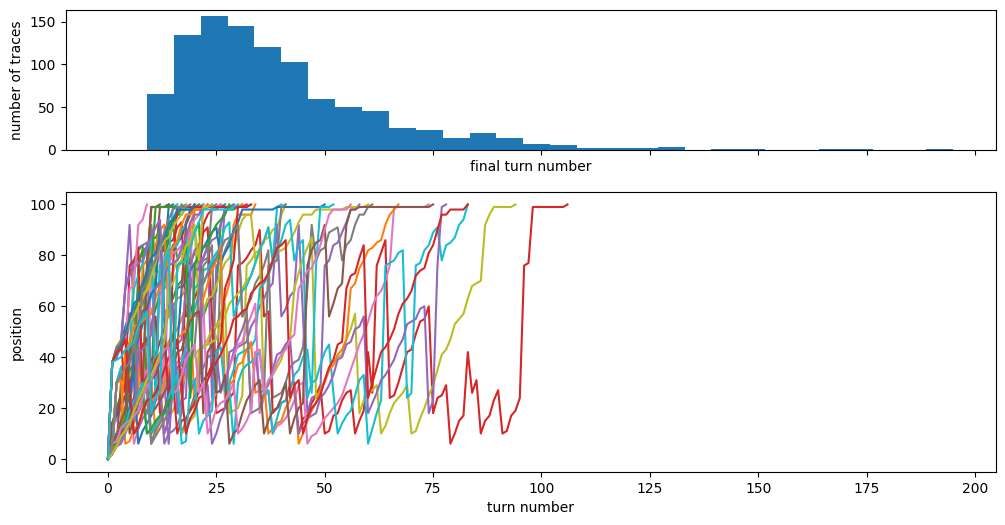

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, height_ratios=[1, 2])

ax[0].hist([len(trace) for trace in sample_traces], bins=30)
ax[0].set_ylabel('number of traces')
ax[0].set_xlabel('final turn number')

for trace in sample_traces[:50]:
  ax[1].plot([s.state.position for s in trace])

ax[1].set_ylabel('position')
ax[1].set_xlabel('turn number')

None

### Part e
For the Snakes and Ladders game, calculate the expected number of rolls to finish the game. Hint: in order to calculate this, extend the Snakes and Ladders `FiniteMarkovProcess` to an appropriate `FiniteMarkovRewardProcess` instance. What should be the Rewards model in this MRP so you can use one of the methods in the `FiniteMarkovRewardProcess` class to determine the expected number of dice rolls to finish the game?

expected_rolls=33.627 for variant='overshoot_okay'
expected_rolls=41.026 for variant='bounce'
expected_rolls=38.609 for variant='no_overshooting'


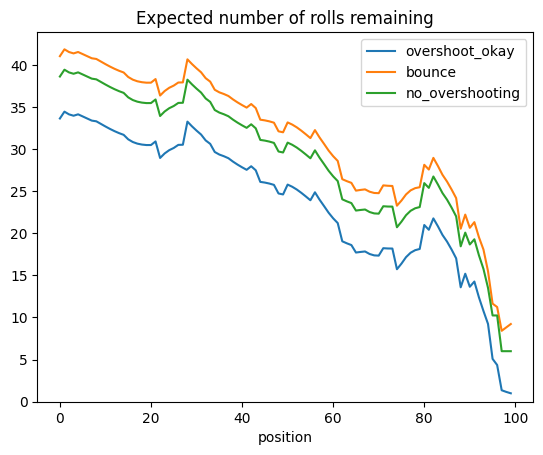

In [10]:
for variant in variants:
  # Keep the usual transitions, but include a reward of 1.0 for each transition.
  transition_reward_map = {SLState(i): transition(SLState(i), variant).map(lambda x: (x, 1.0)) for i in range(100)}
  sl_mrp = FiniteMarkovRewardProcess(transition_reward_map)
  value_function = sl_mrp.get_value_function_vec(gamma=1.0)
  positions = [s.state.position for s in sl_mrp.non_terminal_states]
  expected_rolls = value_function[positions.index(0)]
  print(f'{expected_rolls=:.3f} for {variant=}')
  plt.plot(positions, value_function, label=variant)

plt.xlabel('position')
plt.title('Expected number of rolls remaining')
plt.ylim(bottom=0)
plt.legend()
None

## Question 2
Consider the problem of a frog jumping across a river with $n=9$ lilypads. The frog at every time step will randomly jump to a position in front of it (e.g. at the starting step, the frog will jump with $\frac{1}{10}$ probability to each of the lilypads or $\frac{1}{10}$ to the other side of the river). A diagram of the frog jumping problem is below.

![2_jumping.png](https://github.com/coverdrive/technical-documents/blob/master/finance/cme241/assignments/Winter2024/Figures/2_jumping.png?raw=true)

### Part a
Formalize the states of the jumping frog problem as well as the structure of the transition probabilites.

In [11]:
@dataclass(frozen=True)
class FrogState:
  position: int

# We include a reward of 1.0 for each transition so that the value of a state
# is the expected number of jumps to termination.
transition_reward_map = {
    FrogState(i): Categorical({(FrogState(j), 1.0): 1.0 / (10 - i) for j in range(i + 1, 11)})
    for i in range(10)
}

### Part b
Compute the expected number of steps that it would take for the frog to reach the other side.

In [12]:
frog_mrp = FiniteMarkovRewardProcess(transition_reward_map)
value_function = frog_mrp.get_value_function_vec(gamma=1.0)
positions = [s.state.position for s in frog_mrp.non_terminal_states]
print('Expected number of jumps:', value_function[positions.index(0)])

Expected number of jumps: 2.9289682539682547


### Part c
Provide a closed form solution for the expected number of steps / jumps to cross the river for arbitrary $n$. A formal proof is not required.

Let $f(n)$ denote the expected number of jumps for $n$ lilypads. Then since the frog has an equal chance of jumping to any position in front of it and each jump has a "reward" of 1, we have
$$
f(n) = 1 + \frac 1n \sum_{i=1}^{n-1} f(i)
$$
We use this to prove by induction that $f(n)$ is the $n$-th partial summand of the harmonic series:
$$
\boxed{f(n) = \sum_{k=1}^n \frac 1k}
$$
We have the base case: $f(1) = 1 = \frac 11$, and for $n > 1$, we have
$$\begin{align}
f(n) &= 1 + \frac 1n \sum_{i=1}^{n-1}f(i) \\
  &= 1 + \frac 1n \sum_{i=1}^{n-1} \sum_{k=1}^i \frac 1k \\
  &= 1 + \frac 1n \sum_{k=1}^{n-1} \frac{n-k}{k}
  \qquad\qquad \text{(since $\frac 1k$ appears $n-k$ times above)} \\
  &= 1 + \frac 1n \sum_{k=1}^{n-1} \Bigl(\frac nk - 1\Bigr) \\
  &= 1 - \frac{n-1}n + \sum_{k=1}^{n-1} \frac 1k \\
  &= \sum_{k=1}^n \frac 1k
\end{align}$$

## Question 3
Consider an MDP with an infinite set of states $\mathcal{S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by: $$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in \mathcal{S} \text{ for all } a \in [0,1]$$
For all states $s \in \mathcal{S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Part a
Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in \mathcal{S}$

The problem has translational symmetry. The map $f\colon \mathcal S\to \mathcal S$ given by $f(s) = s + 1$ has the properties that
* $f$ is injective
* For any $s$, $s$ and $f(s)$ have the same set of available actions, namely $a\in [0, 1]$.
* For any $s$, $r$, and $a$, $\mathbb P[r, f(s')|f(s), a] = \mathbb P[r, s'|s, a]$. Since $f$ is injective, this "accounts for all the probability", so $\mathbb P[r, s'|f(s), a] = 0$ for any $s'$ not in the image of $f$. In particular, this means that states outside the image of $f$ are not accessible from inside the image of $f$.

It follows that $f$ induces a (value-preserving) bijection between policies from starting position $s$ and policies from starting position $f(s)$. In particular, the optimal value function satisfies $V^*(s) = V^*(s+1)$ for all $s$, so all states have the same value, $v$. The Bellman equation tells us that this $v$ satisfies
$$\begin{align}
v &= \max_a\Bigl(a\cdot \bigl((1-a) + \gamma v\bigr) + (1-a) \cdot \bigl((1+a) + \gamma v\bigr)\Bigr) \\
&= \max_a\Bigl(1 + a - 2a^2 + \gamma v\Bigr)
\end{align}$$
Taking the derivative of the argument of $\max$ with respect to $a$, we have that the maximum occurs when $1 - 4a = 0$, or $a=\frac 14$, giving
$$
v = \frac 98 + \gamma v\\
v = \frac 98\cdot \frac{1}{1-\gamma}
$$
For $\gamma = 0.5$, we have $\boxed{V^*(s) = v = \frac 94\text{ for all }s}$.

### Part b
Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in \mathcal{S}$

As shown above, the optimial policy is to $\boxed{\text{always pick }a=\frac 14}$.

## Question 4
Consider again the problem of a frog jumping across a river with $n-1$ lilypads, labeled $1, \dots, n-1$, with the two riverbanks labeled positions $0$ and $n$. At each time step, the frog who is at lilypad $i$ has two options:
- (Strategy A) The frog moves to lilypad $i-1$  with probability $\frac{i}{n}$ and moves to lilypad $i+1$ otherwise.
- (Strategy B) The frog moves to arbitrary position from $0,\dots,n$ with equal probability.

The frog now starts on a random lilypad. A snake lives on one end of the river (say the snake lives at 0) and will eat the frog if it lands on this side of the river. The frog can escape by landing the other side of the river (i.e. position $n$). What should the frog's strategy be when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (reaching $n$ before reaching $0$)? Although there are more than one ways of solving this problem, we would like to solve it by modeling it as an MDP and identifying the Optimal Policy.

Note: Sorry for all the frog jumping questions. These games are an easy way to understand Markov Processes, without having to build out too much detail of a financial simulation. Questions will be more related to finance over time.

### Part a
Express with clear mathematical notation the state space, the action space, transition function, and rewards function of an MDP so that the frog-escape problem would be solved by arriving at the Optimal Value Function (and hence, the Optimal Policy) of the MDP.

The state space corresponds to the positions $\mathcal S = \{0, \dots, n\}$ is, with $0$ and $n$ being terminal states. From any non-terminal state, there are two actions, $A$ and $B$, corresponding to following strategy A or B, respectively. The transition probabilities are given by
$$\begin{align}
p(s'|s, a=A) &= \begin{cases}
  \frac{n-s}{n} & s' = s + 1 \\
  \frac{s}{n} & s' = s - 1 \\
  0 & \text{otherwise} \\
\end{cases} \\
p(s'|s, a=B) &= \frac{1}{n+1}
\end{align}$$
All transitions have a reward of 0, with the exception of transitions to the state $n$, which has a reward of 1. This means that the value function is equal to the probability of the frog escaping.

### Part b
Write code to model this MDP as an instance of the `FiniteMarkovDecisionProcess` class. We have learnt that there exists an optimal deterministic policy, and there are $2^{n-1}$ possible deterministic policies for this problem. Write code to create each of these $2^{n-1}$ deterministic policies (as instances of `FinitePolicy` class), create a policy-implied Finite MRP for each of these deterministic policies (using the `apply_finite_policy` method of `FiniteMarkovDecisionProcess` class), and evaluate the Value Function for each of those implied Finite MRPs (using the `get_value_function_vec` method of `FiniteMarkovRewardProcess` class). This should gives you the Optimal Value Function and the Optimal Deterministic Policy.

In [13]:
@dataclass(frozen=True)
class FState:
  i: int
  n: int

  def reward(self) -> float:
    return 1.0 if self.i == self.n else 0.0


def transitionA(state: FState) -> Distribution[FState]:
  i, n = state.i, state.n
  return Categorical(
      {(next_state, next_state.reward()): prob for next_state, prob in [
           (FState(i - 1, n), i / n),
           (FState(i + 1, n),  (n - i) / n),
      ]})


def transitionB(state: FState) -> Distribution[FState]:
  n = state.n
  return Categorical({(FState(j, n), FState(j, n).reward()): 1.0 / (n + 1) for j in range(n + 1)})


def frog_mdp_mapping(n: int):
  """The MDP mapping for the Frog MDP with n - 1 lilypads."""
  return {FState(i, n): {'A': transitionA(FState(i, n)),
                         'B': transitionB(FState(i, n))}
          for i in range(1, n)}

In [14]:
# An example: the MDP for 3 lilypads.
frog_mdp = FiniteMarkovDecisionProcess(frog_mdp_mapping(4))
frog_mdp

From State FState(i=1, n=4):
  With Action A:
    To [Terminal State FState(i=0, n=4) and Reward 0.000] with Probability 0.250
    To [State FState(i=2, n=4) and Reward 0.000] with Probability 0.750
  With Action B:
    To [Terminal State FState(i=0, n=4) and Reward 0.000] with Probability 0.200
    To [State FState(i=1, n=4) and Reward 0.000] with Probability 0.200
    To [State FState(i=2, n=4) and Reward 0.000] with Probability 0.200
    To [State FState(i=3, n=4) and Reward 0.000] with Probability 0.200
    To [Terminal State FState(i=4, n=4) and Reward 1.000] with Probability 0.200
From State FState(i=2, n=4):
  With Action A:
    To [State FState(i=1, n=4) and Reward 0.000] with Probability 0.500
    To [State FState(i=3, n=4) and Reward 0.000] with Probability 0.500
  With Action B:
    To [Terminal State FState(i=0, n=4) and Reward 0.000] with Probability 0.200
    To [State FState(i=1, n=4) and Reward 0.000] with Probability 0.200
    To [State FState(i=2, n=4) and Reward 0.00

In [15]:
def deterministic_policies(n: int) -> Iterator[FinitePolicy[FState, str]]:
  """Yields all deterministic policies for n - 1 lilypads."""
  for choices in itertools.product('AB', repeat=n - 1):
    yield FiniteDeterministicPolicy({FState(i + 1, n): a for i, a in enumerate(choices)})


def brute_force_optimal_policy_and_value(frog_mdp) -> tuple[FiniteDeterministicPolicy[FState, str], np.ndarray]:
  n = len(frog_mdp.non_terminal_states) + 1

  optimal_policy = None
  optimal_value = None
  for policy in deterministic_policies(n):
    frog_mrp = frog_mdp.apply_finite_policy(policy)
    value = frog_mrp.get_value_function_vec(gamma=1.0)
    if optimal_policy is None or (value > optimal_value).all():
      optimal_policy = policy
      optimal_value = value
  return optimal_policy, optimal_value

In [16]:
frog_mdp = FiniteMarkovDecisionProcess(frog_mdp_mapping(9))
policy, value = brute_force_optimal_policy_and_value(frog_mdp)
print(f'Optimal policy:\n{policy}')
print('Optimal value function:\n' + '\n'.join(f'State i={s.state.i} has value {v}' for s, v in zip(frog_mdp.non_terminal_states, value)))

Optimal policy:
For State FState(i=1, n=9): Do Action B
For State FState(i=2, n=9): Do Action A
For State FState(i=3, n=9): Do Action A
For State FState(i=4, n=9): Do Action A
For State FState(i=5, n=9): Do Action A
For State FState(i=6, n=9): Do Action A
For State FState(i=7, n=9): Do Action A
For State FState(i=8, n=9): Do Action A

Optimal value function:
State i=1 has value 0.6756756756756744
State i=2 has value 0.705236486486485
State i=3 has value 0.7136824324324308
State i=4 has value 0.7179054054054037
State i=5 has value 0.721283783783782
State i=6 has value 0.725506756756755
State i=7 has value 0.7339527027027011
State i=8 has value 0.763513513513512


### Part c
Plot a graph of the Optimal Escape-Probability and of the associated strategies, as a function of the states of this MDP, for $n=3, n=6$ and $n=9$. By looking at the results on this graph, what pattern do you observe for the optimal policy as you vary $n$ from 3 to 9?

It looks like the optimal policy is "do B if you're on lilypad 1, and A otherwise."

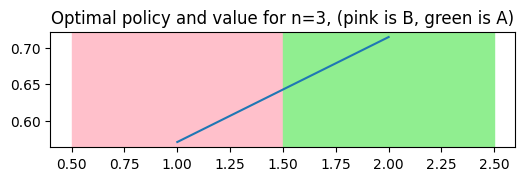

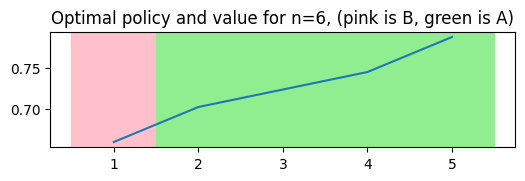

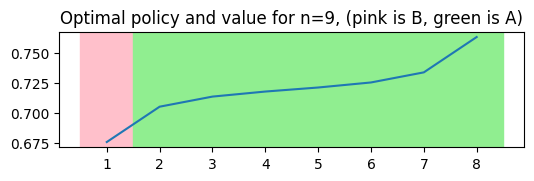

In [17]:
for n in [3, 6, 9]:
  frog_mdp = FiniteMarkovDecisionProcess(frog_mdp_mapping(n))
  policy, value = brute_force_optimal_policy_and_value(frog_mdp)
  position = np.array([s.state.i for s in frog_mdp.non_terminal_states])
  plt.figure(figsize=(6, 1.5))
  for state in frog_mdp.non_terminal_states:
    action = policy.act(state).value
    i = state.state.i
    plt.axvspan(i-.5, i+.5, color={'A': 'lightgreen', 'B': 'pink'}[action])
  plt.plot(position, value)
  plt.title(f'Optimal policy and value for {n=}, (pink is B, green is A)')
  plt.show()

![2_frog.png](https://github.com/coverdrive/technical-documents/blob/master/finance/cme241/assignments/Winter2024/Figures/2_frog.png?raw=true)